# Build  spectra for AuxTel

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : March 30th 2021
- creation update : March 31th 2021
- update on CC : July 7th 2021
- version v1
- work with kernel anaconda3_auxtel (also anaconda3_auxtel_v2)

This notebook is to help for finding the position of order 0

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
from iminuit import Minuit
import iminuit

In [3]:
iminuit.__version__

'2.2.0'

In [4]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [5]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

# Function

In [6]:
def file_target(filename):
    m=re.findall('^Cor_holo4_003_.*_(.*)_[0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*[.]fits$',filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []

# Path

In [7]:
path_auxtel="/sps/lsst/groups/auxtel"
path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
path_spectractor_config=os.path.join(path_spectractor,"config")
path_images=os.path.join(path_auxtel,"data/2021/holo/FlipCleans")

# Logbook for file selection

In [8]:
!ls logbooks

auxtellogbook_2021_v1.3.csv   auxtelronchi170lpmmlogbook_2021_v0.3.csv
auxtellogbook_2021_v1.3.xlsx  auxtelronchi170lpmmlogbook_2021_v0.3.xlsx


In [9]:
filename_logbook='logbooks/auxtellogbook_2021_v1.3.csv'

In [10]:
df=pd.read_csv(filename_logbook,index_col=0)

In [11]:
pd.set_option('display.max_rows', None)

In [12]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-02-17T01:45:09.091,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_RG610_HD50896_2021-02-16_181.fits,181,HD50896,RG610,holo4_003,1.006209,90.0,...,10.3,51.0,9.3,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2021-02-17T03:37:12.647,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_empty_HD50896_2021-02-16_209.fits,209,HD50896,empty_1,holo4_003,1.099905,90.0,...,10.4,45.0,9.9,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2021-02-18T07:25:02.387,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_350.fits,350,NGC4755,empty_1,holo4_003,1.158253,6.0,...,8.8,53.0,7.3,750.0,2700.0,NaN,NaN,,1.0,1.0
3,3,2021-02-18T07:25:46.560,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_351.fits,351,NGC4755,empty_1,holo4_003,1.158097,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
4,4,2021-02-18T07:26:07.146,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_352.fits,352,NGC4755,empty_1,holo4_003,1.158027,6.0,...,8.8,54.0,6.3,750.0,2700.0,NaN,NaN,,1.0,1.0
5,5,2021-02-18T07:26:18.957,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_353.fits,353,NGC4755,empty_1,holo4_003,1.157987,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
6,6,2021-02-18T07:26:43.049,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_354.fits,354,NGC4755,empty_1,holo4_003,1.157907,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
7,7,2021-02-18T07:26:51.615,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_355.fits,355,NGC4755,empty_1,holo4_003,1.157879,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
8,8,2021-02-18T07:27:00.190,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_356.fits,356,NGC4755,empty_1,holo4_003,1.157851,6.0,...,8.8,55.0,7.7,750.0,2700.0,NaN,NaN,,1.0,1.0
9,9,2021-02-18T07:27:53.863,/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans,Cor_holo4_003_NGC4755_2021-02-17_357.fits,357,NGC4755,empty_1,holo4_003,1.157723,6.0,...,8.7,55.0,6.7,700.0,1700.0,NaN,NaN,,1.0,1.0


# Selection of input file

In [13]:
dir_images=path_images

In [14]:
#filename_image="Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits"

In [15]:
# 2021/03/31
#filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits' reconstruit à moitié
#filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'
#filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'
#filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'
#filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits' BAD image
#filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits' BOUGE
#filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits' BOUGE
#filename_image=df['file'][58] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits' BOUGE
#filename_image=df['file'][59] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits' BOUGE
#filename_image=df['file'][60] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits' BOUGE
#filename_image=df['file'][61] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits' PLANTE
#filename_image=df['file'][62] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_291.fits' BAD PSF
#filename_image=df['file'][63] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_292.fits' GOOD
#filename_image=df['file'][64] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_293.fits' GOOD
#filename_image=df['file'][65] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_294.fits' GOOD
#filename_image=df['file'][66] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_295.fits' GOOD
#filename_image=df['file'][67] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits' GOOD
#filename_image=df['file'][68] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_297.fits' BAD PSF
#filename_image=df['file'][69] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_298.fits' BAD PSF
#filename_image=df['file'][70] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_299.fits' BAD PSF
#filename_image=df['file'][71] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_300.fits' BAD PSF
#filename_image=df['file'][72] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_301.fits' PLANTE
#filename_image=df['file'][73] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_302.fits' PLANTE
#filename_image=df['file'][74] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_303.fits' BAD FOCUS
#filename_image=df['file'][75] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_304.fits' BAD FOCUS

# 2021/04/01

#filename_image=df['file'][1] # 'Cor_holo4_003_empty_HD50896_2021-02-16_209.fits'  pas d'ordre 0

#filename_image=df['file'][2] # 'Cor_holo4_003_NGC4755_2021-02-17_350.fits'  GOOD PSF
filename_image=df['file'][3] # 'Cor_holo4_003_NGC4755_2021-02-17_351.fits'  GOOD PSF
#filename_image=df['file'][4] # 'Cor_holo4_003_NGC4755_2021-02-17_352.fits'  GOOD PSF
#filename_image=df['file'][5] # 'Cor_holo4_003_NGC4755_2021-02-17_353.fits'  GOOD PSF
#filename_image=df['file'][6] # 'Cor_holo4_003_NGC4755_2021-02-17_354.fits'  GOOD PSF
#filename_image=df['file'][7] # 'Cor_holo4_003_NGC4755_2021-02-17_355.fits'  GOOD PSF
#filename_image=df['file'][8] # 'Cor_holo4_003_NGC4755_2021-02-17_356.fits'  GOOD PSF
#filename_image=df['file'][9] # 'Cor_holo4_003_NGC4755_2021-02-17_357.fits'  GOOD PSF
#filename_image=df['file'][10] # 'Cor_holo4_003_NGC4755_2021-02-17_358.fits'  GOOD PSF
#filename_image=df['file'][11] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits'  GOOD PSF
#filename_image=df['file'][12] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits'  defocused, failed
#filename_image=df['file'][13] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits'  defocused, failed
#filename_image=df['file'][14] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits'  good, but central star
#filename_image=df['file'][15] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits'  bad psf, but looks good
#filename_image=df['file'][16] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits'  Very good
#filename_image=df['file'][17] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits'  Very good
#filename_image=df['file'][18] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits'  Very good
#filename_image=df['file'][19] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits'  Fit bizare
#filename_image=df['file'][20] # 'Cor_holo4_003_empty_HD60753_2021-02-18_566.fits'  Very good
#filename_image=df['file'][21] # 'Cor_holo4_003_empty_HD60753_2021-02-18_567.fits'  Good psf, but rec failed order1/2 separated
#filename_image=df['file'][22] # 'Cor_holo4_003_empty_HD60753_2021-02-18_568.fits'  Good psf,  order1/2 separated
#filename_image=df['file'][23] # 'Cor_holo4_003_empty_HD60753_2021-02-18_569.fits'  Good psf,  order1/2 separ
#filename_image=df['file'][24] # 'Cor_holo4_003_empty_HD60753_2021-02-18_570.fits'  Good psf,  order1/2 separ
#filename_image=df['file'][25] # 'Cor_holo4_003_empty_HD60753_2021-02-18_571.fits'  Good psf, failed , order1/2 separ
#filename_image=df['file'][26] # 'Cor_holo4_003_empty_HD60753_2021-02-18_572.fits'  Good psf, good rec,order1/2 separ
#filename_image=df['file'][27] # 'Cor_holo4_003_empty_HD60753_2021-02-18_573.fits'  Bad psf, order1/2 separ
#filename_image=df['file'][28] # 'Cor_holo4_003_empty_HD60753_2021-02-18_574.fits'  Bad psf, order1/2 separ
#filename_image=df['file'][29] # 'Cor_holo4_003_empty_HD60753_2021-02-18_575.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][30] # 'Cor_holo4_003_empty_HD60753_2021-02-18_576.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][31] # 'Cor_holo4_003_empty_HD60753_2021-02-18_577.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][32] # 'Cor_holo4_003_empty_HD60753_2021-02-18_578.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][33] # 'Cor_holo4_003_empty_HD60753_2021-02-18_579.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][34] # 'Cor_holo4_003_empty_HD60753_2021-02-18_580.fits'   Bad psf, order1/2 separ
#filename_image=df['file'][35] # 'Cor_holo4_003_empty_HD60753_2021-02-18_581.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][36] # 'Cor_holo4_003_empty_HD60753_2021-02-18_582.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][38] # 'Cor_holo4_003_empty_HD60753_2021-02-18_584.fits'   Bad psf, order1/2 separ, bad rec ?
#filename_image=df['file'][39] # 'Cor_holo4_003_empty_HD60753_2021-02-18_585.fits'   Bad psf, order1/2 separ, bad rec
#filename_image=df['file'][40] # 'Cor_holo4_003_empty_HD60753_2021-02-18_586.fits'   Bad psf, order1/2 separ, good rec 
#filename_image=df['file'][41] # 'Cor_holo4_003_empty_HD60753_2021-02-18_587.fits'   Bad psf, order1/2 separ, good rec
#filename_image=df['file'][42] # 'Cor_holo4_003_empty_HD60753_2021-02-18_588.fits'   Bad Focus, order1/2 separ, bad rec
#filename_image=df['file'][43] # 'Cor_holo4_003_empty_HD60753_2021-02-18_590.fits'   NOTHING Bad Focus, order1/2 separ, good rec
#filename_image=df['file'][44] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits'   BAD Not focued
#filename_image=df['file'][45] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits'   BAD Not focued
#filename_image=df['file'][46] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits'   BAD Not focued
#filename_image=df['file'][47] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits'   BAD Not focued
#filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'   BAD Not focued
#filename_image=df['file'][49] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits'   bad psf + rec OK
#filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'   bad psf + rec OK
#filename_image=df['file'][51] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits'   bad psf + rec OK
#filename_image=df['file'][52] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits'   bad psf + rec OK
#filename_image=df['file'][53] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits'   bad psf + rec OK
#filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'   bad psf + rec OK
#filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits'   bad psf + rec OK
#filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits'   bad focus bad psf + rec OK
#filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits'   bad focus bad psf + rec OK

In [16]:
filename_image

'Cor_holo4_003_NGC4755_2021-02-17_351.fits'

In [17]:
file_target(filename_image)

['NGC4755']

In [18]:
#spectractor_dir="/Users/dagoret/MacOSX/GitHub/LSST/SpectractorNew/spectractor"

In [19]:
filename=os.path.join(dir_images,filename_image)
output_directory="./outputs_process_holo/"
output_figures="figures_process_holo"
#guess = [xpos,ypos]
guess = [250,2600]
disperser_label = "holo4_003"
config =  os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
target = file_target(filename_image)[0]

# Configuration of the running mode

In [20]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

In [21]:
#parameters.DISPERSER_DIR = os.path.join(spectractor_dir, "extractor/dispersers/")
#parameters.CONFIG_DIR = os.path.join(spectractor_dir, "../config/")
#parameters.THROUGHPUT_DIR = os.path.join(spectractor_dir, "simulation/CTIOThroughput/")

# Load an image

In [22]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

## Show relevant parameters

In [23]:
parameters.OBS_NAME

'AUXTEL'

In [24]:
parameters.DISPERSER_DIR

'/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [25]:
parameters.DISTANCE2CCD

174.9980010986328

In [26]:
parameters.LAMBDA_MIN 

300

In [27]:
parameters.LAMBDA_MAX 

1100

In [28]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [29]:
image.filter_label

''

In [30]:
image.header["FILTER"]

'empty_1'

In [31]:
image.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-02-18T07:25:18.438'                                             
DATE-OBS= '2021-02-18T07:25:18.438'                                             
DATE-BEG= '2021-02-18T07:25:46.560'                                             
DATE-END= '2021-02-18T07:25:52.806'                                             
MJD     =      59263.309241177                                                  
MJD-OBS =     59263.3095666646                                                  
MJD-BEG =     59263.30956666

# Plot image and find the target position

In [32]:
filename_image

'Cor_holo4_003_NGC4755_2021-02-17_351.fits'

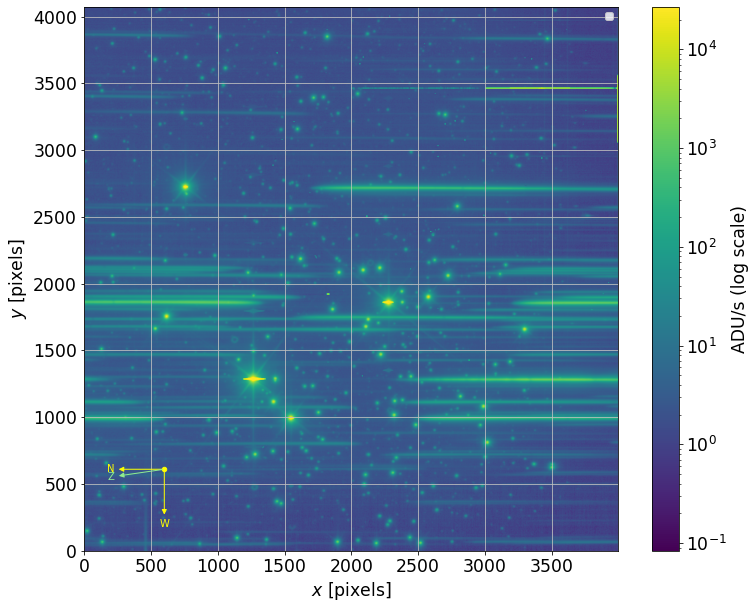

In [33]:
image.plot_image(figsize=(12, 10),scale="log")

In [34]:
#alert False

Cor_holo4_003_NGC4755_2021-02-17_351.fits


2021-07-07 17:12:47  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                 c0_1       
    ----------------- -------------------- -------------------
    6.399138559415517 0.016106855838911076 0.04626061561910799
2021-07-07 17:12:48  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 11 iterations because the relative change of cost is below ftol=1.25e-05.


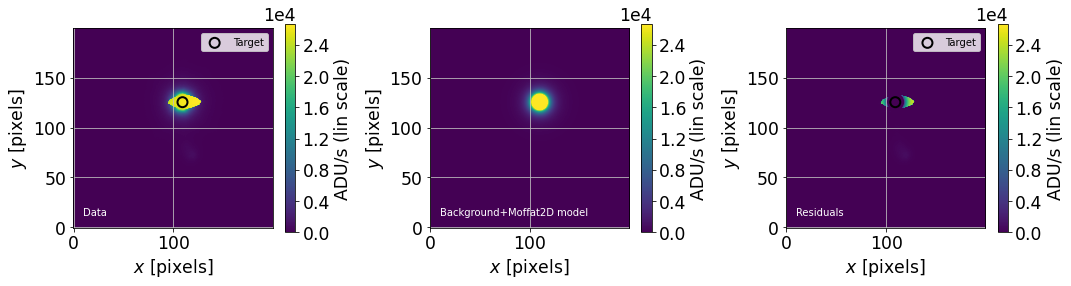

2021-07-07 17:12:51  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


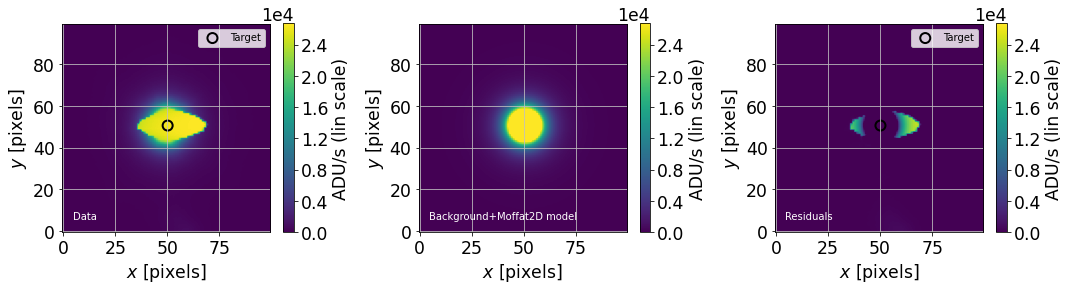

In [35]:
#guess = [2000, 2800]
#guess = [400, 2700] # filename_image=df['file'][37] : Cor_holo4_003_empty_HD60753_2021-02-18_583.fits'
#guess = [300, 2300] #filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'
#guess = [300, 2500] #filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_283.fits'
#guess = [300, 2500] #filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_284.fits' BAD image
#guess = [300, 2500]  #filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_285.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][57] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_286.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][58] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_287.fits' MOVED
#guess = [300, 2500]  #filename_image=df['file'][59] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_288.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][60] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_289.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][61] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_290.fits' PLANTE
#guess = [300, 2500]  #filename_image=df['file'][62] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_291.fits' BAD PSF
#guess = [300, 2500]  #filename_image=df['file'][63] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_292.fits'  GOOD
#guess = [300, 2500]  #filename_image=df['file'][64] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_293.fits' GOOD
#guess = [300, 2500]  #filename_image=df['file'][65] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_294.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][66] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_295.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][67] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_296.fits' GOOD
#guess = [300, 2600]  #filename_image=df['file'][68] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_297.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][69] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_298.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][70] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_299.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][71] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_300.fits' BAD PSF
#guess = [300, 2600]  #filename_image=df['file'][72] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_301.fits' PLANTE
#guess = [300, 2600]  #filename_image=df['file'][73] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_302.fits' PLANTE
#guess = [300, 2600]  #filename_image=df['file'][74] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_303.fits' TOO BAD FOCUS
#guess = [300, 2600]  #filename_image=df['file'][75] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_304.fits' TOO BAD FOCUS


#guess = [750, 2700] #filename_image=df['file'][2] # 'Cor_holo4_003_NGC4755_2021-02-17_350.fits' GOOD PSF  
guess = [750, 2700] #filename_image=df['file'][3] # 'Cor_holo4_003_NGC4755_2021-02-17_351.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][4] # 'Cor_holo4_003_NGC4755_2021-02-17_352.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][5] # 'Cor_holo4_003_NGC4755_2021-02-17_353.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][6] # 'Cor_holo4_003_NGC4755_2021-02-17_354.fits' GOOD PSF 
#guess = [750, 2700] #filename_image=df['file'][7] # 'Cor_holo4_003_NGC4755_2021-02-17_355.fits' GOOD PSF
#guess = [750, 2700] #filename_image=df['file'][8] # 'Cor_holo4_003_NGC4755_2021-02-17_356.fits' GOOD PSF
#guess = [700, 1700] #filename_image=df['file'][9] # 'Cor_holo4_003_NGC4755_2021-02-17_357.fits' GOOD PSF
#guess = [500, 1800] #filename_image=df['file'][10] # 'Cor_holo4_003_NGC4755_2021-02-17_358.fits' GOOD PSF
#guess = [300, 2500] #filename_image=df['file'][11] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_556.fits'  GOOD PSF
#guess = [400, 2600] #filename_image=df['file'][12] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_557.fits'  Defocused, failed
#guess = [350, 2600] #filename_image=df['file'][13] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_558.fits' Defoc, failed
#guess = [1800, 2500] #filename_image=df['file'][14] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_559.fits' Good, but central star
#guess = [400, 2500] #filename_image=df['file'][15] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_560.fits' bad psf, but seems good
#guess = [400, 2500] #filename_image=df['file'][16] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_561.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][17] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_562.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][18] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_563.fits' GOOD PSF
#guess = [400, 2500] #filename_image=df['file'][19] # 'Cor_holo4_003_RG610_HD60753_2021-02-18_564.fits' GOOD PSF, FIT BIZARRE

#guess = [400, 2600] #filename_image=df['file'][20] # 'Cor_holo4_003_empty_HD60753_2021-02-18_566.fits' GOOD PSF
#guess = [400, 2600] #filename_image=df['file'][21] # 'Cor_holo4_003_empty_HD60753_2021-02-18_567.fits' GOOD PSF, rec failed order1/2 separated
#guess = [400, 2600] #filename_image=df['file'][22] # 'Cor_holo4_003_empty_HD60753_2021-02-18_568.fits' GOOD PSF, rec , order1/2 separated
#guess = [400, 2600] #filename_image=df['file'][23] # 'Cor_holo4_003_empty_HD60753_2021-02-18_569.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][24] # 'Cor_holo4_003_empty_HD60753_2021-02-18_570.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][25] # 'Cor_holo4_003_empty_HD60753_2021-02-18_571.fits' GOOD PSF, failed rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][26] # 'Cor_holo4_003_empty_HD60753_2021-02-18_572.fits' GOOD PSF, good rec, order1/2 separated on plate
#guess = [400, 2600] #filename_image=df['file'][27] # 'Cor_holo4_003_empty_HD60753_2021-02-18_573.fits' BAD PSF, rec, order1/2 separated on plate
#guess = [400, 2700] #filename_image=df['file'][28] # 'Cor_holo4_003_empty_HD60753_2021-02-18_574.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][29] # 'Cor_holo4_003_empty_HD60753_2021-02-18_575.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][30] # 'Cor_holo4_003_empty_HD60753_2021-02-18_576.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][31] # 'Cor_holo4_003_empty_HD60753_2021-02-18_577.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][32] # 'Cor_holo4_003_empty_HD60753_2021-02-18_578.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][33] # 'Cor_holo4_003_empty_HD60753_2021-02-18_579.fits' BAD PSF, rec, order1/2 separa
#guess = [400, 2700] #filename_image=df['file'][34] # 'Cor_holo4_003_empty_HD60753_2021-02-18_580.fits' BAD PSF, rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][35] # 'Cor_holo4_003_empty_HD60753_2021-02-18_581.fits' BAD PSF, rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][36] # 'Cor_holo4_003_empty_HD60753_2021-02-18_582.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][37] # 'Cor_holo4_003_empty_HD60753_2021-02-18_583.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][38] # 'Cor_holo4_003_empty_HD60753_2021-02-18_584.fits' BAD PSF, probably bad rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][39] # 'Cor_holo4_003_empty_HD60753_2021-02-18_585.fits' BAD PSF, probably good rec, order1/2 separa
#guess= [400, 2700] #filename_image=df['file'][40] # 'Cor_holo4_003_empty_HD60753_2021-02-18_586.fits' BAD PSF, Good rec, order1/2 separa
#guess= [1900, 2900] #filename_image=df['file'][41] # 'Cor_holo4_003_empty_HD60753_2021-02-18_587.fits' BAD PSF, Good rec, order1/2 separa, inutile
#guess= [1900, 2900] #filename_image=df['file'][42] # 'Cor_holo4_003_empty_HD60753_2021-02-18_588.fits' BAD FOCUS, Good rec, order1/2 separa, inutile
#guess= [1900, 2900] #filename_image=df['file'][43] # 'Cor_holo4_003_empty_HD60753_2021-02-18_590.fits' NOTHING BAD FOCUS, Good rec, order1/2 separa, inutile
#guess= [1900, 2900] #filename_image=df['file'][44] # '# 'Cor_holo4_003_RG610_HD114449_2021-02-18_591.fits' BAD FOCUS
#guess= [1900, 2900] #filename_image=df['file'][45] # '# 'Cor_holo4_003_RG610_HD114449_2021-02-18_592.fits'

#guess= [1900, 2900] #filename_image=df['file'][46] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_593.fits'   BAD Not focued
#guess= [1900, 2900] #filename_image=df['file'][47] # 'Cor_holo4_003_RG610_HD114449_2021-02-18_594.fits'   BAD Not focued
#guess= [1900, 2900] #filename_image=df['file'][48] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_165.fits'   BAD Not focued
#guess= [200, 2400] #filename_image=df['file'][49] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_166.fits'   bad psf , good reconstruction
#guess= [300, 2300] #filename_image=df['file'][50] # 'Cor_holo4_003_RG610_HR3439_2021-03-11_167.fits'   bad psf , good reconstruction

#guess= [1700, 2300] #filename_image=df['file'][51] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_191.fits'   bad psf + rec OK
#guess= [1700, 2300] #filename_image=df['file'][52] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_192.fits'   bad psf + rec OK
#guess= [1700, 2300] #filename_image=df['file'][53] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_193.fits'   bad psf + rec OK
#guess= [250, 2500] #filename_image=df['file'][54] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_194.fits'   bad focus,very bad psf + bad rec 

#guess= [250, 2500] #filename_image=df['file'][55] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_195.fits'   bad focus,very bad psf + bad rec 
#guess= [250, 2500] #filename_image=df['file'][56] # 'Cor_holo4_003_RG610_HD75519_2021-03-11_196.fits'   bad focus,very bad psf + bad rec 



parameters.VERBOSE = True
parameters.DEBUG = True
print(filename_image)
x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)

In [36]:
print(x1,y1)

759.1661323896831 2725.5485282020136


In [37]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [38]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [39]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [40]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

### Global values

In [41]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [42]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [43]:
kurt_str

'kurtosis : K0 = 84.840\n             : Kx = 3.317\n             : Ky = 8.677'

In [44]:
print("kurtosis_test_prob = ",kurtosis_test_prob)
print("skew_test_prob = ",skew_test_prob)
print("norm_test_prob = ",normal_test_prob)

kurtosis_test_prob =  0.0
skew_test_prob =  0.0
norm_test_prob =  0.0


In [45]:
print("kurtosis_test_val = ",kurtosis_test_val)
print("skew_test_val = ",skew_test_val)
print("norm_test_val = ",normal_test_val)

kurtosis_test_val =  122.72634409503777
skew_test_val =  207.1371361571605
norm_test_val =  57967.54871032367


### X

In [46]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

### Y

In [47]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [48]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [49]:
skew_str

'skew     : Sk0 = 9.097\n             : Skx = 2.193\n             : Sky = 3.089\n             : p_test   = 0.000e+00\n             : p_test_x = 1.079e-17\n             : p_test_y = 1.358e-24'

In [50]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [51]:
kurt_str

'kurtosis : K0 = 84.840\n             : Kx = 3.317\n             : Ky = 8.677\n             : p_test   = 0.000e+00\n             : p_test_x = 4.379e-06\n             : p_test_y = 4.035e-11'

In [52]:
norm_str='p_normal_test = {:3.3e}'.format(normal_test_prob)

In [53]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [54]:
norm_str

'normal  : p_test   = 0.000e+00\n             : p_test_x = 3.087e-21\n             : p_test_y = 6.002e-33'

In [55]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

Text(0.05, 0.2, 'normal  : p_test   = 0.000e+00\n             : p_test_x = 3.087e-21\n             : p_test_y = 6.002e-33')

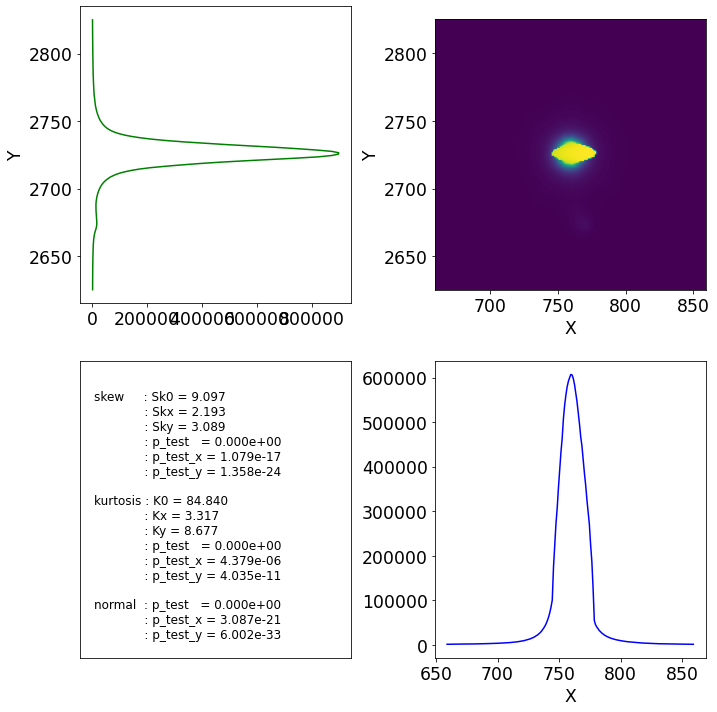

In [56]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
#ax.text(0.05, 0.95, shape_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)

# Go for spectrum reconstruction

2021-07-07 17:12:53  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-07-07 17:12:53  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans/Cor_holo4_003_NGC4755_2021-02-17_351.fits...
2021-07-07 17:12:53  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123	=> parameters.OBS_ALTITUDE: 2.66299616375123	 <class 'float'>
x obs_latitude: -30.2446389756252	=> parameters.OBS_LATITUDE: -30.2446389756252	 <class 'float'>
x obs_diameter: 1.20	=> parameters.OBS_DIAMETER: 1.2 m	 <class 'astropy.units.quantity.Quantity'>
x obs_epoch: J2000.0	=> parameters.OBS_EPOCH: J2000.0	 <class 'str'>
x obs_transmission_systematics: 0.005	=> parameters.OBS_TRANSMISSION_SYSTEMATICS: 0.005	 <c

2021-07-07 17:12:53  Image      load_image           INFO   
	Loading disperser holo4_003...
2021-07-07 17:12:53  Hologram   load_specs           INFO   
	Load disperser holo4_003:
	from /sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/holo4_003
2021-07-07 17:12:53  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 156.00 +/- 1.00 grooves/mm
	Average tilt of -0.3 degrees
2021-07-07 17:12:57  Star       load                 INFO   
	Simbad:
 MAIN_ID     RA      DEC    RA_PREC ... PM_ERR_MINA_2 PM_ERR_ANGLE_2 Z_VALUE_2 
          "h:m:s"  "d:m:s"          ...    mas / yr        deg                 
--------- -------- -------- ------- ... ------------- -------------- ----------
NGC  4755 12 53 39 -60 21.7       4 ...         0.134             90 -0.0000670
2021-07-07 17:12:57  Star       load_spectra         DEBUG  
	Target label: NGC4755
	Calspec? False
	Number of spectra: 0
	Redshift

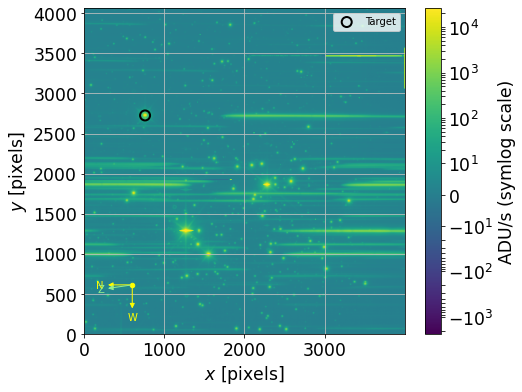

2021-07-07 17:13:02  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 759.16613239 2725.5485282 ]...
2021-07-07 17:13:02  spectractor.extractor.images find_target          INFO   
	No WCS /sps/lsst/groups/auxtel/data/2021/holo/FlipCleans/Cor_holo4_003_NGC4755_2021-02-17_351_wcs/Cor_holo4_003_NGC4755_2021-02-17_351.wcs available, use 2D fit to find target pixel position.
2021-07-07 17:13:03  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                 c1_0                  c0_1         
    ------------------ --------------------- ----------------------
    13.118451289735898 -0.002532230901144246 -0.0034434563698037676
2021-07-07 17:13:03  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 11 iterations because the relative change of cost is below ftol=1.25e-05.


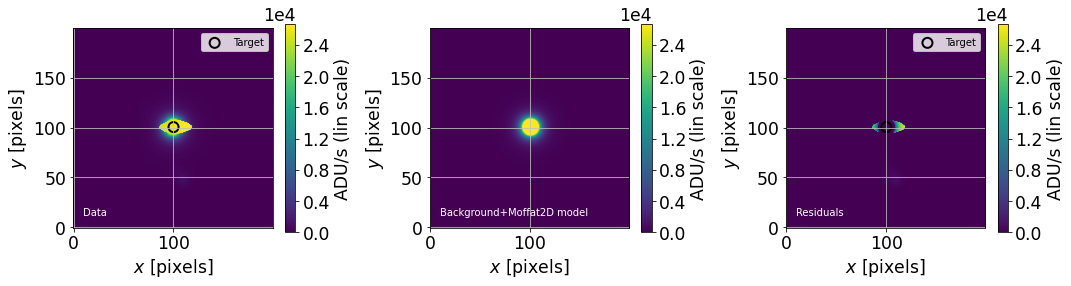

2021-07-07 17:13:04  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


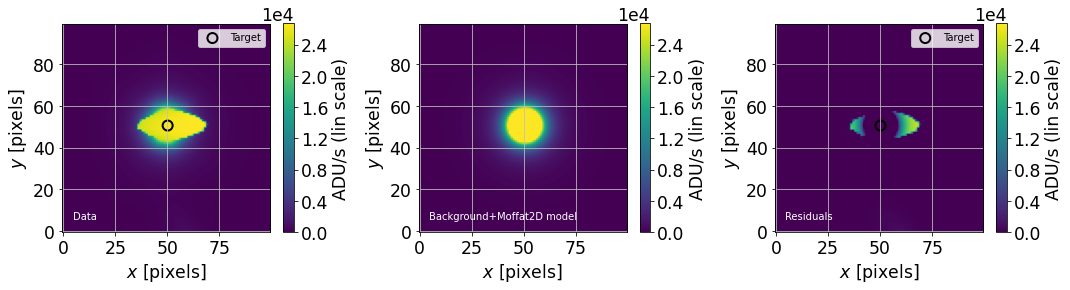

2021-07-07 17:13:05  Image      find_target          INFO   
	X,Y target position in pixels: 759.169,2725.550


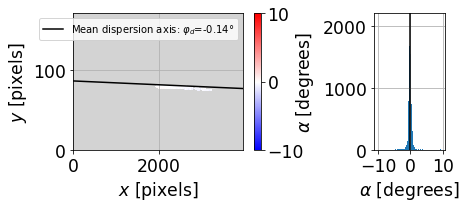

2021-07-07 17:13:06  Image      turn_image           INFO   
	Rotate the image with angle theta=-0.14 degree
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


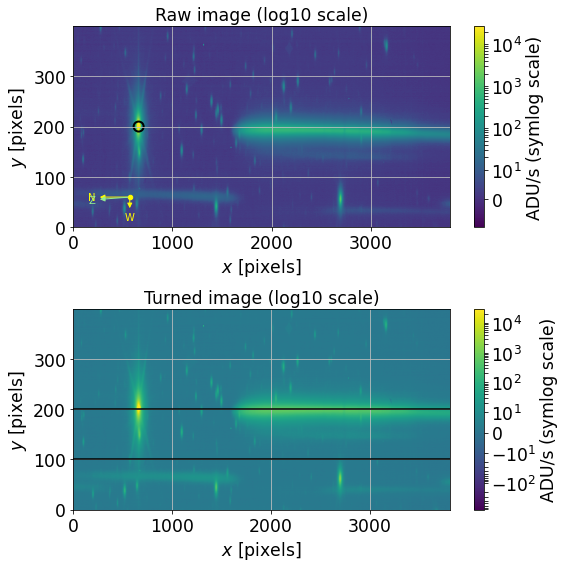

2021-07-07 17:13:16  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-07-07 17:13:16  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0              c1_0               c0_1        
    ----------------- ----------------- --------------------
    98.15427339113731 0.217163963905924 -0.16107960819094136
2021-07-07 17:13:16  Image      find_target_init     DEBUG  
	5 saturated pixels: set saturation level to 28333.333333333332 ADU/s.
2021-07-07 17:13:16  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 6 iterations because the relative change of cost is below ftol=5e-05.


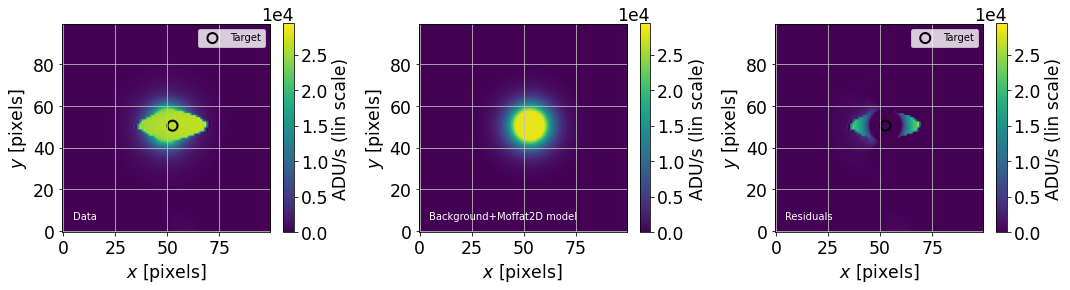

2021-07-07 17:13:17  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=0.0002.


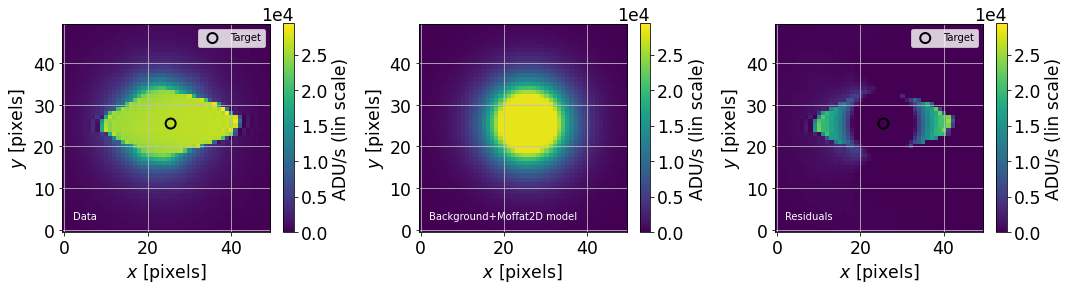

2021-07-07 17:13:17  Image      find_target          INFO   
	X,Y target position in pixels: 764.554,2727.510
2021-07-07 17:13:17  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-07-07 17:13:17  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*40 pixels and background from 140 to 180 pixels
2021-07-07 17:13:18  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [1584:3812,2547:2907] (size (2228, 360))


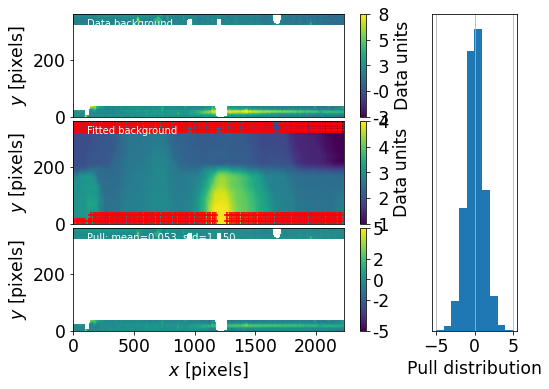

2021-07-07 17:13:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


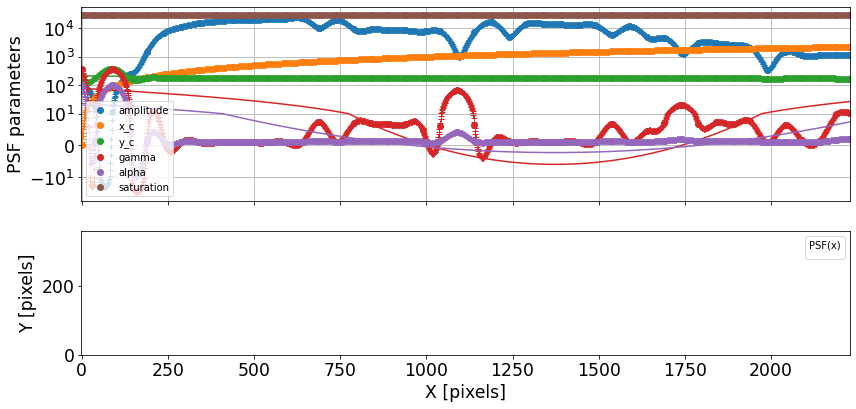

2021-07-07 17:13:53  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=3.4797e+07 initial chisq_red=195.22
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [-0.09406197 -0.04666659  0.18483251 -0.09056618  0.30468758  0.09104245
 -0.44216889  0.18696208 -0.24081684]
	New parameters: [-1.91668219 -0.93729642  0.78495175  1.3839498   0.50256338 -2.0177744
  0.69201449  0.17204298 -0.32461475]
	Final cost=3.4558e+07 final chisq_red=193.88 computed in 3.23s
2021-07-07 17:13:55  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_0 has a null Jacobian; parameter is fixed at its last known current value (0.6920144915371096).
2021-07-07 17:13:55  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_1 has a null Jacobian; parameter is fixed at its last known current value (0.17204297585334846).
2021-07-07 17:13:55  spectractor.fit.fitter gradient_descent     WARNING 
	Step 1: alpha_2 has a null Jacobian; parameter 

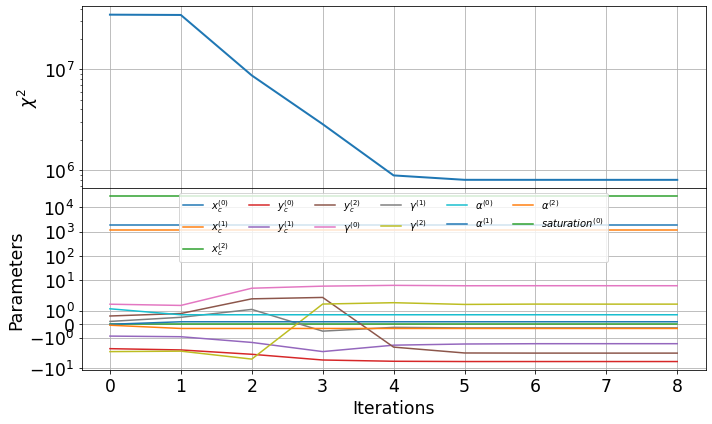

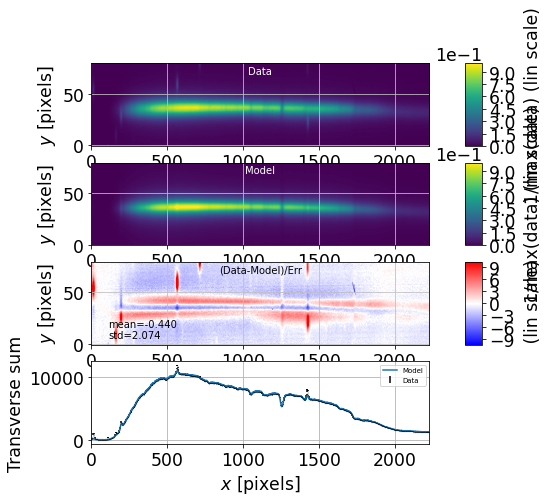

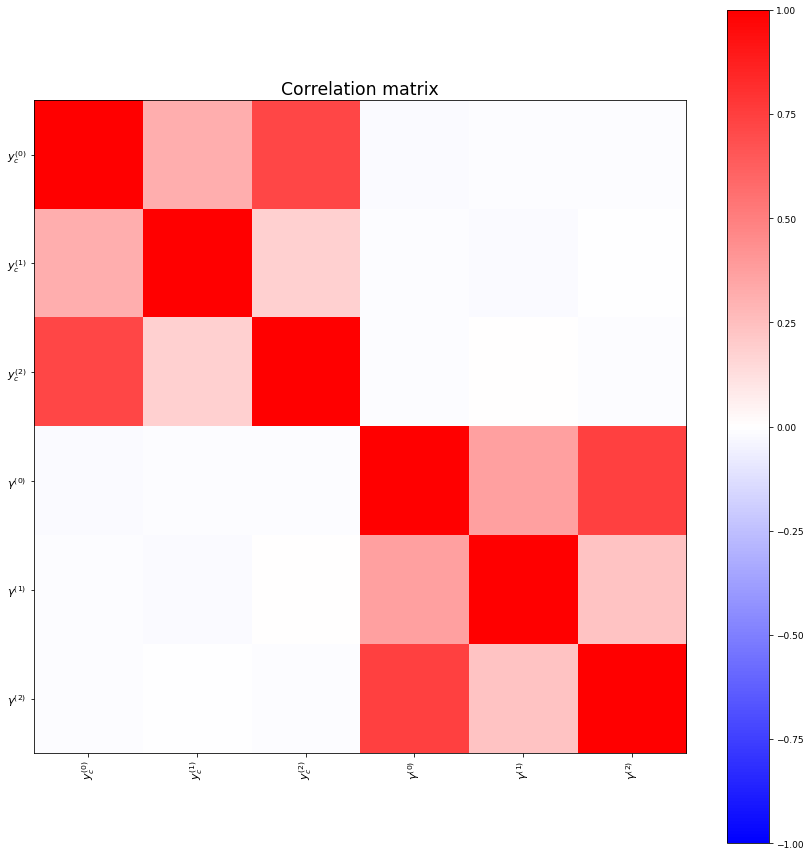

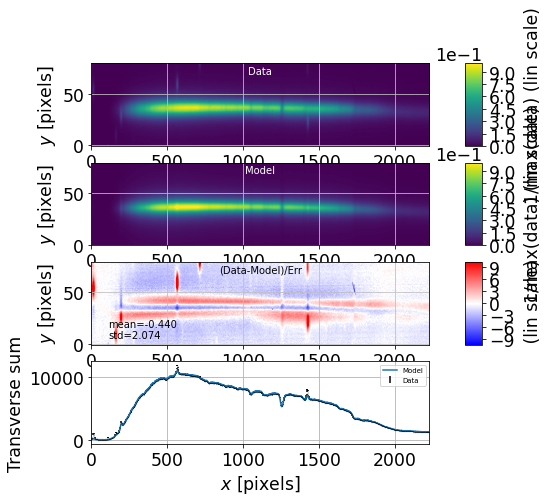

2021-07-07 17:14:18  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
    amplitude       x_c          y_c         ...         Dy         Dy_disp_axis
------------------ ------ ------------------ ... ------------------ ------------
30.742942476854093    0.0 174.12542925008015 ... -6.384812025329808          0.0
 27.97974947775983    1.0  174.1306715148754 ... -6.379569760534565          0.0
 37.23008919131849    2.0 174.13590789668865 ... -6.374333378721303          0.0
 35.95443557804544    3.0 174.14113839551987 ... -6.369102879890079          0.0
 51.05710154114578    4.0 174.14636301136912 ... -6.363878264040835          0.0
59.063056540198886    5.0 174.15158174423632 ... -6.358659531173629          0.0
 61.40151478184838    6.0 174.15679459412155 ... -6.353446681288403          0.0
  78.5194763683073    7.0 174.16200156102474 ... -6.348239714385215          0.0
 73.65515279558478    8.0 174.16720264494595 ... -6.34303863

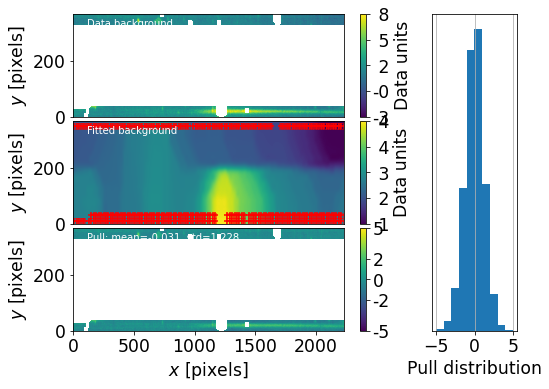

2021-07-07 17:14:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=2.450 ADU/s, RMS=1.685 ADU/s.
2021-07-07 17:14:21  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [1578:3806,2538:2905] (size (2228, 367))
	New target position in spectrogram frame: [-818.8313295428843, 187.5503457834584]


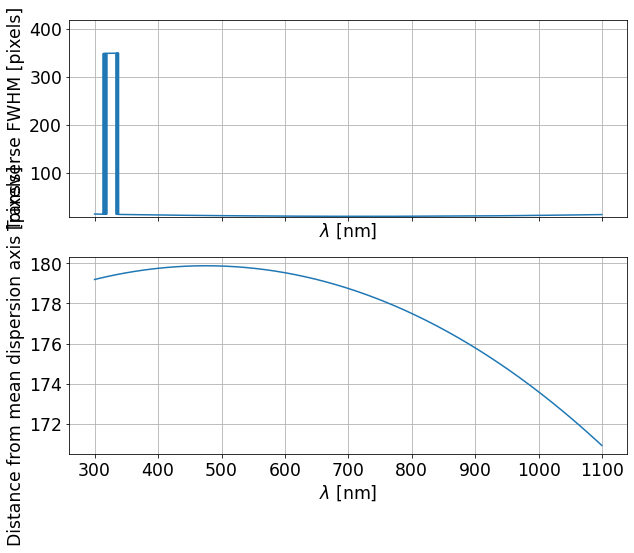

/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1713: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  norm = matplotlib.colors.SymLogNorm(vmin=vmin, vmax=vmax, linthresh=10)


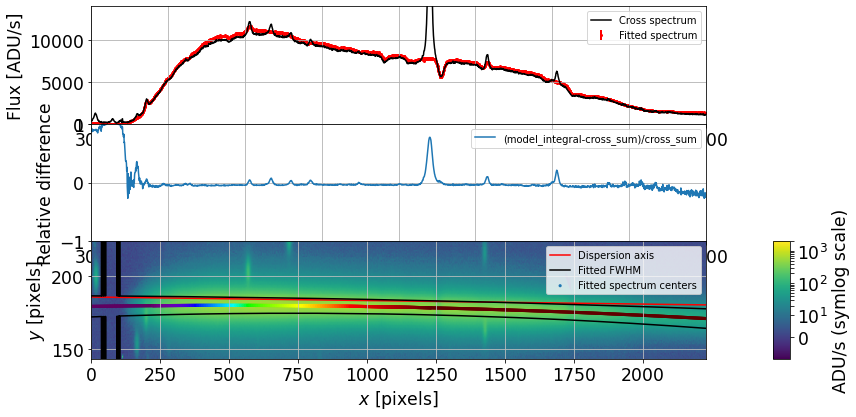

2021-07-07 17:14:24  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


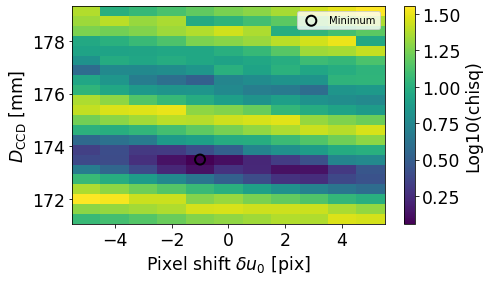

2021-07-07 17:15:18  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.001pix
	D = 173.498 mm (default: DISTANCE2CCD = 175.00 +/- 0.75 mm, -2.0 sigma shift)
2021-07-07 17:15:18  astropy    _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-07-07 17:15:18  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_holo/Cor_holo4_003_NGC4755_2021-02-17_351_spectrum.fits
2021-07-07 17:15:18  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_holo/Cor_holo4_003_NGC4755_2021-02-17_351_spectrogram.fits


   Line   Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
              nm        nm    ...  reduced       nm          nm     
--------- --------- --------- ... --------- ----------- ------------
$H\gamma$     434.0 438.83655 ... 2.1255903 -0.07446475    -0.241972
 $He_{I}$     447.1 452.42877 ... 2.1255903 -0.76436377    -1.974657
$Fe_{II}$     463.8 463.75558 ... 2.1255903  -0.5529929   -1.8700786
$He_{II}$     468.6 473.36823 ... 2.1255903  -0.5117136   -1.7001573
$Fe_{II}$     515.8 511.33063 ... 2.1255903 -0.47046012  -0.61941826
$C_{III}$     570.0   573.627 ... 0.8913087 -0.12868656  -0.48649248
 $He_{I}$     587.5  581.8717 ... 0.8913087 -0.46519703  -0.20654663
$He_{II}$     611.8  611.6206 ... 0.7993356 -0.28870282  -0.56545544
$He_{II}$     617.1  622.6586 ... 0.7993356 -0.13762192  -0.39126444
 $O_{II}$     630.0 632.76196 ... 0.7993356 -0.08571854  -0.11096604
      ...       ...       ... ...       ...         ...          ...
 $He_{I}$     781.6  782.1526 ... 

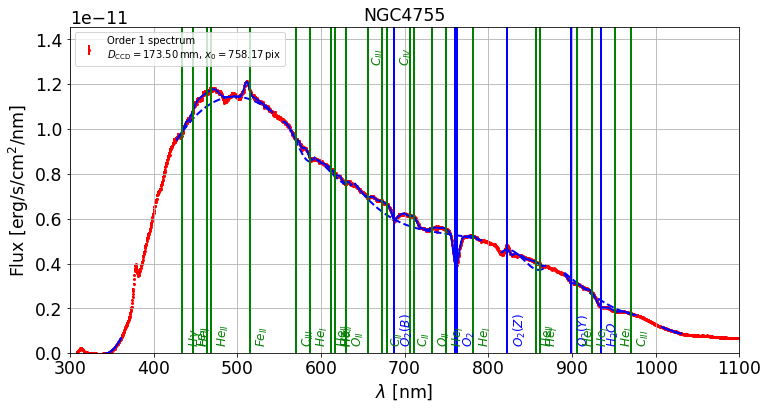

In [57]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)